Finding kT as in T = k_t * rpm^2

In [1151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Data
RPM = np.array([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
Thrust = np.array([0.1, 0.4, 0.9, 1.6, 2.4, 3.5, 4.7, 6.1, 7.7, 9.4])
Torque = np.array([0.123, 0.896, 2.909, 6.707, 12.854, 21.913, 34.437, 51.02, 71.472, 97.613])

def fit_func(x, a):
    return a * x**2

params, covariance = curve_fit(fit_func, RPM, Thrust)
params2, covariance2 = curve_fit(fit_func, RPM, Torque)
thrust_coef = params[0]
torque_coef = params2[0]

Define Functions

In [1154]:
def thrust_from_rpm(rpm):
    return thrust_coef * rpm**2

def torque_from_rpm(rpm):
    return torque_coef * rpm**2

def thrust(T1_rpm, T2_rpm, T3_rpm, T4_rpm):
    return np.array([0, 0, thrust_from_rpm(T1_rpm) + thrust_from_rpm(T2_rpm) +
                     thrust_from_rpm(T3_rpm) + thrust_from_rpm(T4_rpm)])

def torques(T1_rpm, T2_rpm, T3_rpm, T4_rpm, L):
    return np.array([
        L * (thrust_from_rpm(T2_rpm) - thrust_from_rpm(T4_rpm)),  # Roll torque
        L * (thrust_from_rpm(T3_rpm) - thrust_from_rpm(T1_rpm)),  # Pitch torque
        torque_from_rpm(T1_rpm) - torque_from_rpm(T2_rpm) +
        torque_from_rpm(T3_rpm) - torque_from_rpm(T4_rpm)  # Yaw torque
    ])

def rotation_matrix(phi, theta, psi):
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(phi), -np.sin(phi)],
                    [0, np.sin(phi), np.cos(phi)]])
    R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                    [0, 1, 0],
                    [-np.sin(theta), 0, np.cos(theta)]])
    R_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])
    return R_z @ R_y @ R_x

def angular_acceleration(tau, omega, I):
    return np.linalg.inv(I) @ (tau - np.cross(omega, I @ omega))

def omega_to_thetadot(omega, phi, theta):
    S = np.array([
        [1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta)],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi) / np.cos(theta), np.cos(phi) / np.cos(theta)]
    ])
    return S @ omega

def linear_acceleration(T, theta, xdot, m, g):
    gravity = np.array([0, 0, -g])
    R = rotation_matrix(*theta)
    return gravity + (1 / m) * (R @ T)

# Task 1

Simulation Setup for Hover

In [1177]:
#Quadcopter parameters
m = 0.6887
g = 9.81
L = 0.2
Ixx, Iyy, Izz = 0.02, 0.02, 0.011
I = np.diag([Ixx, Iyy, Izz])
thrust_coef = params[0]

#Simulation Parameters
x = np.array([0, 0, 1]) #Initial Position
xdot = np.zeros(3)  #Initial Linear velocity
theta = np.zeros(3)  #Initial Euler angles
thetadot = np.zeros(3)  #Initial Angular velocity
omega = np.zeros(3)  #Initial Angular velocity in body frame

#Simulation settings & holder
dt = 0.01
hover_duration = 60 
times = np.arange(0, hover_duration + dt, dt)
trajectory = []
attitude = []
rpms = []

#Calculate hover RPM
T_hover_per_rotor = m * g / 4
rpm_hover = np.sqrt(T_hover_per_rotor / thrust_coef)
#check if exceed motor limits
if rpm_hover <= 1000:
    print("Warning: Potential Inaccurate Thrust Data.")
elif rpm_hover >= 10000:
    print("Error: RPM Exceeds limits, check thrust_coef or weight of drone")

#Define proportional control gain for altitude adjustment
k_p = 1.0  #Proportional gain (tune this value for desired stability)

#Hovering
for t in times:
    # Real Time Thrust adjustments
    altitude_error = 1.0 - x[2]
    adjusted_thrust = m * g + k_p * altitude_error
    rpm_hover_dynamic = np.sqrt(adjusted_thrust / (4 * thrust_coef))
    rpms.append(rpm_hover_dynamic)
    
    # Motor limits
    if rpm_hover_dynamic >= 9000:
        print("Error: RPM exceeds motor limits")
        break
    #Compute thrust and torques
    T = thrust(rpm_hover_dynamic, rpm_hover_dynamic, rpm_hover_dynamic, rpm_hover_dynamic)
    tau = torques(rpm_hover_dynamic, rpm_hover_dynamic, rpm_hover_dynamic, rpm_hover_dynamic, L)
    a = linear_acceleration(T, theta, xdot, m, g)
    omegadot = angular_acceleration(tau, omega, I)

    #Update States
    xdot = xdot + dt * a
    x = x + dt * xdot
    omega = omega + dt * omegadot
    thetadot = omega_to_thetadot(omega, theta[0], theta[1])
    theta = theta + dt * thetadot

    #Storing
    trajectory.append(x.copy())
    attitude.append(theta.copy())

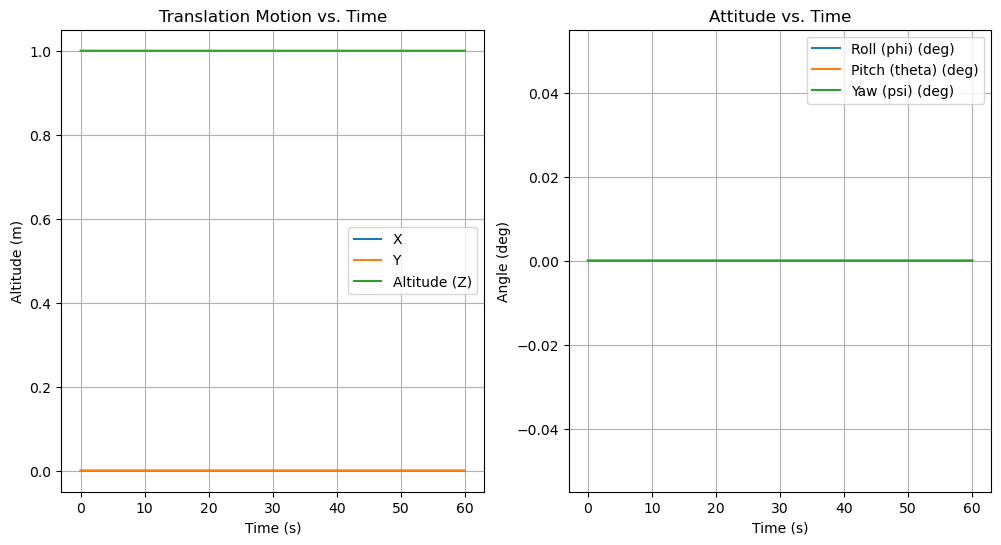

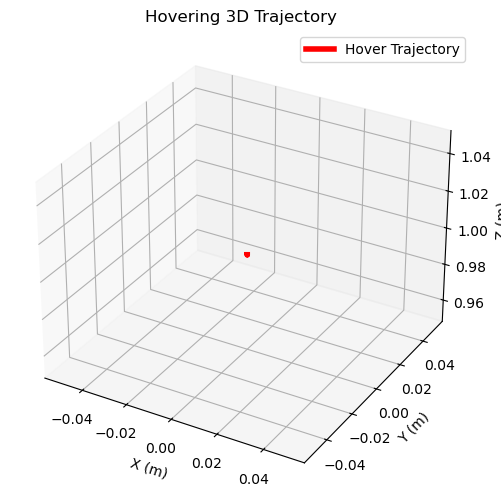

In [1179]:
#Ploting Hover motion

trajectory = np.array(trajectory)
attitude = np.array(attitude)
rpms = np.array(rpms)
total_times = np.linspace(0, len(trajectory) * dt, len(trajectory))
np.savetxt("attitude.txt", attitude, fmt='%d', delimiter=',')

# Ploting Hovering DoFs
fig1 = plt.figure(figsize=(12, 6))
ax1 = fig1.add_subplot(121)
ax1.plot(total_times, trajectory[:, 0], label='X')
ax1.plot(total_times, trajectory[:, 1], label='Y')
ax1.plot(total_times, trajectory[:, 2], label='Altitude (Z)')
ax1.set_title('Translation Motion vs. Time')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Altitude (m)')
ax1.legend()
ax1.grid()
ax3 = fig1.add_subplot(122)
ax3.plot(total_times, np.rad2deg(attitude[:, 0]), label='Roll (phi) (deg)')
ax3.plot(total_times, np.rad2deg(attitude[:, 1]), label='Pitch (theta) (deg)')
ax3.plot(total_times, np.rad2deg(attitude[:, 2]), label='Yaw (psi) (deg)')
ax3.set_title('Attitude vs. Time')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Angle (deg)')
ax3.legend()
ax3.grid()
fig1.savefig('hovering task plots.png')

#3D Visualization
fig2 = plt.figure(figsize=(12, 6))
ax1 = fig2.add_subplot(111, projection='3d')
ax1.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2],'r-', label='Hover Trajectory',lw=4)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('Hovering 3D Trajectory')
ax1.legend()
fig2.savefig('hovering 3D Traj.png')

# Task 2

In [1163]:
#Simulation task parameters
dt = 0.05
total_time = 60
times = np.arange(0, total_time, dt)
m = 0.667
g = 9.81
L = 0.2
k_T = thrust_coef
k_Q = 8.58589e-7 
radius = 2.0
speed = 0.5
omega = speed / radius  # Angular velocity around the circle

# Initializing
phi, theta, psi_body = 0.1, -0.05, 0.2

IK solver function

In [1166]:
def quadrotor_ik(pos_d, vel_d, acc_d, yaw_d, m, g, L, thrust_coef, k_Q, Ixx, Iyy, Izz):
    # Calculate required forces
    F_gravity = np.array([0, 0, -m * g])
    F_centripetal = m * acc_d
    F_total = F_centripetal + F_gravity
    F_x, F_y, F_z = F_total

    # Desired torques
    tau_phi = Ixx * F_y / g
    tau_theta = Iyy * F_x / g
    tau_psi = Izz * (yaw_d - psi_body) / dt

    # Motor thrust calculation
    A = np.array([
        [1, 1, 1, 1],
        [0, L, 0, -L],
        [-L, 0, L, 0],
        [k_Q, -k_Q, k_Q, -k_Q]
    ])
    b = np.array([F_z, tau_phi, tau_theta, tau_psi])
    motor_thrusts = np.maximum(np.linalg.solve(A, b), 0)
    motor_rpms = np.sqrt(motor_thrusts / thrust_coef)

    return motor_thrusts, motor_rpms

Simulation

In [1169]:
trajectory = []
attitude = []

for t in times:
    # Desired trajectory
    x_d = radius * np.cos(omega * t)
    y_d = radius * np.sin(omega * t)
    z_d = 1.0
    pos_d = np.array([x_d, y_d, z_d])

    x_dot_d = -radius * omega * np.sin(omega * t)
    y_dot_d = radius * omega * np.cos(omega * t)
    z_dot_d = 0.0
    vel_d = np.array([x_dot_d, y_dot_d, z_dot_d])

    x_ddot_d = -radius * omega**2 * np.cos(omega * t)
    y_ddot_d = -radius * omega**2 * np.sin(omega * t)
    z_ddot_d = 0.0
    acc_d = np.array([x_ddot_d, y_ddot_d, z_ddot_d])

    yaw_d = omega * t

    # Inverse kinematics
    motor_thrusts, motor_rpms = quadrotor_ik(pos_d, vel_d, acc_d, yaw_d, m, g, L, thrust_coef, k_Q, Ixx, Iyy, Izz)

    # Forward kinematics
    tau_x = L * (motor_thrusts[1] - motor_thrusts[3])
    tau_y = L * (motor_thrusts[2] - motor_thrusts[0])
    tau_z = k_Q * (motor_thrusts[0] - motor_thrusts[1] + motor_thrusts[2] - motor_thrusts[3])

    alpha_x = tau_x / Ixx
    alpha_y = tau_y / Iyy
    alpha_z = tau_z / Izz

    phi += alpha_x * dt
    theta += alpha_y * dt
    yaw_rate_body = alpha_z * dt
    psi_body += yaw_rate_body * dt

    # Storage
    trajectory.append(pos_d)
    attitude.append([phi, theta, psi_body])

trajectory = np.array(trajectory)
attitude = np.array(attitude)

Plotting

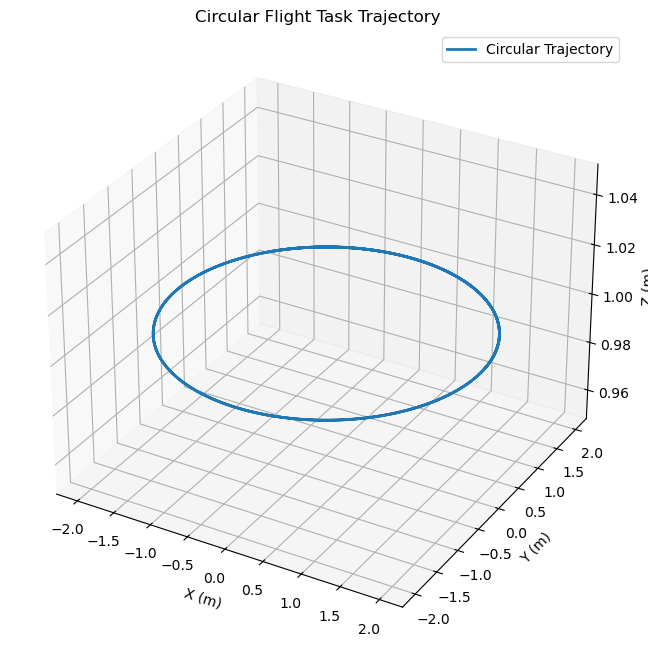

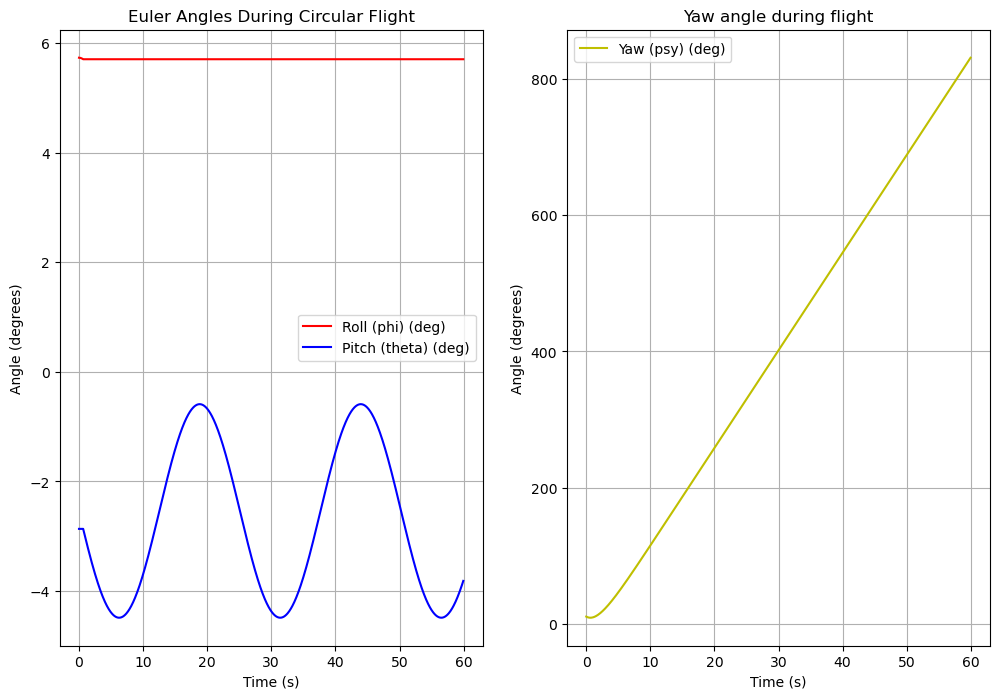

In [1172]:
#Plot the 3D trajectory
fig3 = plt.figure(figsize=(12, 8))
ax1 = fig3.add_subplot(111, projection='3d')
ax1.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='Circular Trajectory', linewidth=2)
ax1.set_title('Circular Flight Task Trajectory')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.legend()

#Plot Attitude
fig4 = plt.figure(figsize=(12, 8))
ax1 = fig4.add_subplot(121)
ax1.plot(times, np.rad2deg(attitude[:, 0]), 'r-', label='Roll (phi) (deg)')
ax1.plot(times, np.rad2deg(attitude[:, 1]), 'b-', label='Pitch (theta) (deg)')
ax1.set_title('Euler Angles During Circular Flight')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Angle (degrees)')
ax1.legend()
ax1.grid()
ax2 = fig4.add_subplot(122)
ax2.plot(times, np.rad2deg(attitude[:, 2]), 'y-', label='Yaw (psy) (deg)')
ax2.set_title('Yaw angle during flight')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angle (degrees)')
ax2.legend()
ax2.grid()

fig3.savefig('Drone task 2 traj.png')
fig4.savefig('drone task 2 atti.png')